# Identification of organic compounds from their refractive index using deep learning

---
This notebook is for a model developed using UV region data only



In [ ]:
# Install keras
# !pip install keras==2.1.6

In [ ]:
#load the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

#New imports
# %tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# tf.keras.utils.to_categorical
%matplotlib inline

In [ ]:
# Mounting google drive, to be able to write & read files on it
# This code block can only run on colab.research.google.com (Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing our scrapped data, currently using github hosted file.
This data is a result of web scrapping "refractiveindex.info" website


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/innokirigiti/mypublicfolder/main/riScrappedData.csv")
df.head()

,book,wl,n,k
0,CH4 (Methane),1.68,1.000436,NaN
1,CH4 (Methane),1.94,1.000436,NaN
2,CH4 (Methane),2.67,1.000433,NaN
3,CH4 (Methane),2.79,1.000431,NaN
4,CH4 (Methane),2.96,1.000428,NaN


# Data visualization and pre-processing

## Handling missing values

In [ ]:
# Shape of the dataframe
df.shape

(248756, 4)

In [ ]:
# Counting null values from each column
df.isna().sum()

book       0
wl         0
n          0
k       9645
dtype: int64

There are 9645 missing values of K

In [ ]:
# Replacing all missing values of K with zero
df['k'].fillna(0, inplace = True)

In [ ]:
# Confirming we have handled NUll k values
df.isna().sum()

book    0
wl      0
n       0
k       0
dtype: int64

## One hot encoding targets (Classes of organic compounds) with integers

In [ ]:
# Get unique values of classes, sort them to ensure always the same order

# encode class values as integers
encoder = LabelEncoder()
df['book'] = encoder.fit_transform(df['book'])

# This is our dictionary for decoding the labels 
# (Same order as indices of probabilities from NN prediction)
classes_dictionary = dict(zip(encoder.transform(encoder.classes_), encoder.classes_,))
classes_dictionary = str(classes_dictionary) 

# Write our dictionary to a json file
import json
	
# Write to current runtime
with open("classes_dictionary.json", "w") as outfile:
	json.dump(classes_dictionary, outfile)

# Write to google drive
with open("/content/drive/MyDrive/colab_data/DLOrganicClassifierData/classes_dictionary.json", "w") as outfile:
	json.dump(classes_dictionary, outfile)

## Grouping data by wavelengths
i.e 'UV', 'Visible', 'Near_IR', 'IR', 'Far_IR'

In [ ]:
# Shuffling data to make it random
df = df.sample(frac=1).reset_index(drop= True)
df.head()

,book,wl,n,k
0,47,3.11989,1.42657,0.009915
1,28,2.67241,1.35228,0.000210
2,47,2.12532,1.42588,0.000103
3,49,3.45857,1.51870,0.000628
4,41,1.80356,1.52082,0.000025


In [ ]:
# Classifying the wavelengths to different categories,based on the range of Wavelengths
df['wl_range'] = pd.cut(df['wl'], [0,0.4,0.75,1.5,4.0, np.inf], labels= ['UV', 'Visible', 'Near_IR', 'IR', 'Far_IR'])
df.sample(3)

,book,wl,n,k,wl_range
108029,6,2.83640,1.39851,0.000110,IR
236109,14,8.28324,1.55065,0.003688,Far_IR
194880,18,3.50833,1.33488,0.001150,IR


Let’s see how many of each class is in our data set

In [ ]:
df['wl_range'].value_counts()

IR         129252
Far_IR      73576
Near_IR     37853
Visible      6268
UV           1807
Name: wl_range, dtype: int64

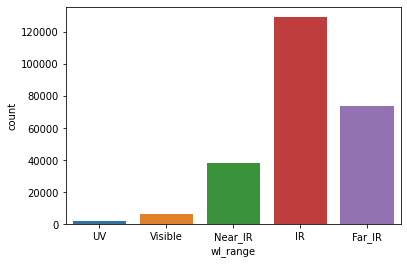

In [ ]:
# Visualising
sns.countplot(x ='wl_range', data = df)

In [ ]:
# Lets select only rows within UV
df = df.loc[df['wl_range'].isin(['UV'])]
df.head()

,book,wl,n,k,wl_range
25,45,0.3648,1.535430,0.000000,UV
53,46,0.3260,1.423960,0.000000,UV
142,20,0.2244,1.510000,0.000002,UV
157,39,0.3991,1.364941,0.000000,UV
378,57,0.3684,1.652826,0.000000,UV


In [ ]:
# Describe new df with only UV data
df.describe()

,book,wl,n,k
count,1807.000000,1807.000000,1807.000000,1807.000000
mean,26.862203,0.309580,1.438435,0.012906
std,13.813236,0.072240,0.084086,0.081545
min,0.000000,0.002000,0.837000,0.000000
25%,20.000000,0.262650,1.395500,0.000000
50%,24.000000,0.329200,1.434995,0.000000
75%,38.000000,0.365781,1.468475,0.000004
max,57.000000,0.400000,2.010000,0.809000


In [ ]:
df.shape

(1807, 5)

## Feature selection/extraction
Creating predictors(X) and Targets(y) for Training and testing the Deep Learning model.

In [ ]:
# Predictors / Features (X)
x = df.drop(['book', 'wl_range'], axis=1)

# Target (y)
y = df['book']   # Taget Vector

print('Shapes of Predictors & Targets')

print('Predictors (X): ', np.shape(x))
print('Targets (y): ', np.shape(y))

Shapes of Predictors & Targets
Predictors (X):  (1807, 3)
Targets (y):  (1807,)


## Normalizing Data


In [ ]:
x_norm = (x - x.mean()) / x.std()
x_norm.sample(10)

,wl,n,k
185673,-1.546486,0.489318,-0.157460
101393,1.016330,-0.002438,-0.158271
67352,-1.179211,0.125644,-0.158041
3739,-1.029626,0.736920,-0.158251
56554,0.864060,0.827954,-0.158271
29927,-0.592846,-0.421531,-0.158223
112915,-0.769383,0.579939,-0.158259
132534,-0.698785,0.544261,-0.158260
240944,0.578900,-0.482064,-0.158271
113572,1.044016,-0.007077,-0.158271


# Train - Test data splitting 
`80%` for training and `20%` for testing



In [ ]:
# split the data for training and testing
from sklearn.metrics import accuracy_score,classification_report
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size = 0.2,random_state=42)

In [ ]:
print ('X - Train shape: ', x_train.shape)
print ('y - Train shape: ', y_train.shape)

print ('X - Test shape: ', x_test.shape)
print ('y - Test shape: ', y_test.shape)

X - Train shape:  (1445, 3)
y - Train shape:  (1445,)
X - Test shape:  (362, 3)
y - Test shape:  (362,)


In [ ]:
# Converting our target into categorical
# (one hot encode outputs)
# The output of each prediction will be the 58 probalilities of corresponding 
# classes
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_test.shape[1]
print(num_classes)

58


In [ ]:
# Building DL Classifier
# define classification model
def classification_model():
    # create model
    model = keras.Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=(3,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
 
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# build the model
model = classification_model()
epochs = 300

In [ ]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                200       
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 58)                5858      
                                                                 
Total params: 11,158
Trainable params: 11,158
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train, validate & test
# We are removing 30% of data from training set as Validation set
# & Fitting the model (Training)
history = model.fit(x_train, y_train, validation_split = 0.3, epochs = epochs, verbose=2)

Epoch 1/300
32/32 - 1s - loss: 3.7618 - accuracy: 0.2483 - val_loss: 3.4451 - val_accuracy: 0.2926 - 956ms/epoch - 30ms/step
Epoch 2/300
32/32 - 0s - loss: 2.9786 - accuracy: 0.3521 - val_loss: 2.6475 - val_accuracy: 0.2995 - 91ms/epoch - 3ms/step
Epoch 3/300
32/32 - 0s - loss: 2.3029 - accuracy: 0.3986 - val_loss: 2.2424 - val_accuracy: 0.3687 - 91ms/epoch - 3ms/step
Epoch 4/300
32/32 - 0s - loss: 1.9722 - accuracy: 0.4322 - val_loss: 2.0452 - val_accuracy: 0.3756 - 108ms/epoch - 3ms/step
Epoch 5/300
32/32 - 0s - loss: 1.7809 - accuracy: 0.4550 - val_loss: 1.9071 - val_accuracy: 0.3894 - 122ms/epoch - 4ms/step
Epoch 6/300
32/32 - 0s - loss: 1.6527 - accuracy: 0.4679 - val_loss: 1.7990 - val_accuracy: 0.4194 - 86ms/epoch - 3ms/step
Epoch 7/300
32/32 - 0s - loss: 1.5591 - accuracy: 0.4718 - val_loss: 1.7306 - val_accuracy: 0.4124 - 97ms/epoch - 3ms/step
Epoch 8/300
32/32 - 0s - loss: 1.4881 - accuracy: 0.4926 - val_loss: 1.6753 - val_accuracy: 0.4470 - 95ms/epoch - 3ms/step
Epoch 9/300


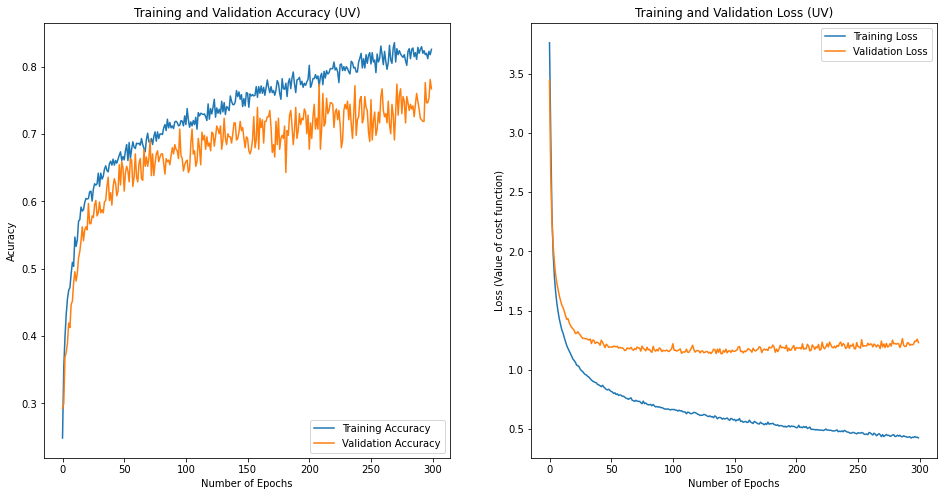

In [ ]:
# Visualizing results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (UV)')
plt.ylabel('Acuracy')
plt.xlabel('Number of Epochs')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (UV)')
plt.ylabel('Loss (Value of cost function)')
plt.xlabel('Number of Epochs')
plt.show()

In [ ]:
# # Save model as h5 (keras model)
# model.save('/content/drive/MyDrive/colab_data/DLOrganicClassifierData/SavedModels/UV_organic_model.h5')

In [ ]:
# # Save the entire model as a SavedModel in drive
# model.save('/content/drive/MyDrive/colab_data/DLOrganicClassifierData/SavedModels/UV_organic_model') 

# Model Evaluation

In [ ]:
# Model Accuracy
scores = model.evaluate(x_test, y_test, verbose=0)
print('The test Accuracy is: ', scores[1])
print('The test Loss is: ', scores[0])

The test Accuracy is:  0.8149171471595764
The test Loss is:  0.9140753746032715


In [ ]:
# Classification report
y_pred = model.predict(x_test) # Whole test set
classes = encoder.classes_.tolist() # Convert our array of labels (classes) to list

predicted_categories = np.argmax(y_pred, axis=1) 
true_categories_argmax = np.argmax(y_test, axis=1)

print(classification_report(true_categories_argmax, predicted_categories, target_names = classes, labels = range (60) ))

                                                  precision    recall  f1-score   support

    (C10H8O4)n (Polyethylene terephthalate, PET)       0.00      0.00      0.00         0
                 (C16H14O3)n (Polycarbonate, PC)       0.00      0.00      0.00         0
  (C2ClF3)n (Polychlorotrifluoroethylene, PCTFE)       0.00      0.00      0.00         0
             (C2H3Cl)n (Polyvinyl chloride, PVC)       0.00      0.00      0.00         0
          (C2H4)n (Polyethylene, PE, HDPE, LDPE)       0.00      0.00      0.00         0
               (C2H4O)n (Polyvinyl alcohol, PVA)       0.00      0.00      0.00         2
         (C2H6OSi)n (Polydimethylsiloxane, PDMS)       0.68      0.86      0.76        44
             (C37H24O6N2)n (Polyetherimide, PEI)       0.00      0.00      0.00         0
                (C3H4O2)n (Polylactic acid, PLA)       0.00      0.00      0.00         0
     (C5H8O2)n (Poly(methyl methacrylate), PMMA)       0.00      0.00      0.00         0
         